# PGD Attack with TensorBoard Tracking

In this notebook, we will demonstrate how to use SecML-Torch to perform a Projected Gradient Descent (PGD) attack while tracking various metrics using TensorBoard integration.

We will:
- Load visualization utilities and dependencies
- Load the CIFAR-10 dataset and a pre-trained robust model
- Configure a PGD attack with multiple tracking capabilities
- Visualize the attack results and tracked metrics using TensorBoard

#### Import dependencies and load utils functions

We install/load SecML‑Torch, RobustBench and TensorBoard (to visualize metrics). If this is your first run, packages and the CIFAR‑10 dataset may be downloaded, which requires internet access.

In [ ]:
%%capture --no-stderr --no-stdout
try:
    import secmlt
except ImportError:
    %pip install git+https://github.com/pralab/secml-torch

try:
    import tensorboard
except ImportError:
    %pip install tensorboard

try:
    import robustbench
except ImportError:
    %pip install robustbench

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# SecML-Torch imports
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.metrics.classification import Accuracy
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.backends import Backends

import warnings
warnings.filterwarnings("ignore")

warnings.simplefilter(action="ignore", category=FutureWarning)

# CIFAR-10 class names
cifar10_classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


def convert_cifar_image(image):
    """Convert tensor image to numpy format for matplotlib display."""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    if image.ndim == 3:
        image = image.transpose((1, 2, 0))  # CHW to HWC
    # Ensure values are in [0, 1] range for display
    image = np.clip(image, 0, 1)
    return image


def show_adversarial_comparison(
    clean_samples,
    adv_samples,
    clean_labels,
    adv_preds,
    title="Clean vs Adversarial Examples",
    n_display=5,
):
    """Display a 3-row grid of clean images, adversarial images, and their perturbations (scaled ×100), showing true labels, predicted labels (color-coded), and the L∞ norm of the unscaled perturbation."""
    n_display = min(n_display, len(clean_samples))
    fig, axes = plt.subplots(3, n_display, figsize=(2.5 * n_display, 8))

    fig.suptitle(title, fontsize=14)

    for idx in range(n_display):
        # Clean image
        clean_img = convert_cifar_image(clean_samples[idx])
        axes[0, idx].imshow(clean_img)
        if idx == 0:
            axes[0, idx].set_ylabel("Clean", fontsize=12)
        axes[0, idx].set_title(
            f"True: {cifar10_classes[clean_labels[idx]]} ({clean_labels[idx]})",
            fontsize=10,
        )
        axes[0, idx].axis("off")

        # Adversarial image
        adv_img = convert_cifar_image(adv_samples[idx])
        axes[1, idx].imshow(adv_img)
        if idx == 0:
            axes[1, idx].set_ylabel("Adversarial", fontsize=12)
        color = "green" if clean_labels[idx] == adv_preds[idx] else "red"
        axes[1, idx].set_title(
            f"Pred: {cifar10_classes[adv_preds[idx]]} ({adv_preds[idx]})",
            color=color,
            fontsize=10,
        )
        axes[1, idx].axis("off")

        # Perturbation (scaled for visibility)
        perturbation = adv_samples[idx] - clean_samples[idx]
        scaled_perturbation = perturbation * 100
        pert_img = convert_cifar_image(scaled_perturbation)
        axes[2, idx].imshow(pert_img)
        if idx == 0:
            axes[2, idx].set_ylabel("Perturbation", fontsize=12)

        # Calculate L∞ norm
        linf_norm = torch.norm(perturbation.view(-1), p=float("inf")).item()
        axes[2, idx].set_title(f"L∞: {linf_norm:.4f} (||δ|| × 100)", fontsize=10)
        axes[2, idx].axis("off")

    plt.tight_layout()
    plt.show()

#### Set device and paths

In [ ]:
# Setup device and paths
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "data/datasets/"
logs_path = "data/logs/pgd_tutorial"

# Create directories if they don't exist
Path(dataset_path).mkdir(parents=True, exist_ok=True)
Path(logs_path).mkdir(parents=True, exist_ok=True)

print(f"Using device: {device}")
print(f"Dataset path: {dataset_path}")
print(f"Logs will be saved to: {logs_path}")

#### Loading CIFAR-10 Dataset

We'll load the CIFAR-10 dataset and use a small subset for demonstration.

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])

test_dataset = torchvision.datasets.CIFAR10(
    root=dataset_path, train=False, download=True, transform=transform
)

num_samples = 20
batch_size = num_samples // 2
test_subset = Subset(test_dataset, list(range(num_samples)))
test_data_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Loaded {len(test_subset)} samples from CIFAR-10 test set")

#### Loading a Pre-trained Robust Model

We'll load a robust model from RobustBench that has been trained to withstand adversarial attacks. We are loading a model that has been adversarially trained against Linf norm adversarial attacks (specified by the "threat_model" field).

In [ ]:
from robustbench.utils import load_model

# Load a robust model from RobustBench
net = load_model(
    model_name="Rade2021Helper_R18_ddpm", dataset="cifar10", threat_model="Linf"
)
net = net.to(device)
net.eval()

# Wrap the model with SecML-Torch's BasePytorchClassifier
model = BasePytorchClassifier(net)

print(f"Loaded robust model: Rade2021Helper_R18_ddpm")

#### Baseline Performance Evaluation

Let's evaluate the model's performance on clean images. We'll later use this information to compare performance degradation of the model, after computing adversarial examples through PGD attack.

In [ ]:
# Test accuracy on clean examples
clean_accuracy = Accuracy()(model, test_data_loader)
print(
    f"Clean accuracy: {clean_accuracy.item():.4f} ({clean_accuracy.item() * 100:.2f}%)"
)

#### Configuring PGD Attack with Tracking

Here we import per-step trackers for loss, predictions, perturbation norm (L∞), and gradient norm, plus the TensorBoard tracker that aggregates these signals and logs them to `logs_path` for visualization. Then we configure PGD hyperparameters and attach the tracker so that every iteration is recorded and viewable in TensorBoard.

In [ ]:
# Import tracking components
from secmlt.trackers import (
    LossTracker,
    PredictionTracker,
    PerturbationNormTracker,
    GradientNormTracker,
    TensorboardTracker,
)

print("Tracking components imported successfully")

In [ ]:
# Configure PGD attack parameters
epsilon = 8 / 255     # Maximum L∞ perturbation
num_steps = 20        # Number of PGD iterations
step_size = 4 / 255   # Step size per iteration
perturbation_model = LpPerturbationModels.LINF  # L∞ norm constraint

print(f"Attack configuration:")
print(f"  - Epsilon: {epsilon:.4f} ({epsilon * 255:.1f}/255)")
print(f"  - Number of steps: {num_steps}")
print(f"  - Step size: {step_size:.4f} ({step_size * 255:.1f}/255)")

In [ ]:
# Set up individual trackers
trackers = [
    LossTracker(),
    PredictionTracker(),
    PerturbationNormTracker("linf"),
    GradientNormTracker(),
]

# Set up TensorBoard tracking
tensorboard_tracker = TensorboardTracker(logs_path, trackers)

print(f"Configured {len(trackers)} trackers with TensorBoard logging")
print(f"TensorBoard logs cleared and will be saved to: {logs_path}")

#### Executing the PGD Attack with Tracking

We instantiate PGD with the chosen hyperparameters and attach the TensorBoard tracker, then run it on the test dataloader. While the attack iterates, the trackers record per-step loss, predictions, perturbation L∞ norms, and gradient norms; these are written to `logs_path` for inspection in TensorBoard. The call returns an adversarial dataset aligned with the input batches, which we use for evaluation and visualization.

In [ ]:
# Create PGD attack with tracking
pgd_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_steps,
    step_size=step_size,
    random_start=False,
    backend=Backends.NATIVE,
    trackers=tensorboard_tracker,
)

print("PGD attack configured successfully")

In [ ]:
# Execute the attack
print("Executing PGD attack with tracking...")
pgd_native_adv_ds = pgd_attack(model, test_data_loader)
print("Attack completed!")

#### Results Analysis

Let's analyze the results of our PGD attack. We expect here to see performance degradation in terms of accuracy, which is the effect of the untargeted PGD attack we just run on our samples.

In [ ]:
# Test accuracy on adversarial examples
adversarial_accuracy = Accuracy()(model, pgd_native_adv_ds)

print("=== Attack Results ===")
print(
    f"Clean accuracy:        {clean_accuracy.item():.4f} ({clean_accuracy.item() * 100:.2f}%)"
)
print(
    f"Adversarial accuracy:  {adversarial_accuracy.item():.4f} ({adversarial_accuracy.item() * 100:.2f}%)"
)
print(
    f"Attack success rate:   {1 - adversarial_accuracy.item():.4f} ({(1 - adversarial_accuracy.item()) * 100:.2f}%)"
)

In [ ]:
# Visualize clean vs adversarial examples
print("Clean vs adversarial examples (the perturbation is amplified):")

# Get samples for visualization
clean_iter = iter(test_data_loader)
clean_images, clean_labels = next(clean_iter)

adv_iter = iter(pgd_native_adv_ds)
adv_images, adv_labels = next(adv_iter)

# Get predictions
clean_preds = model.predict(clean_images.to(device))
adv_preds = model.predict(adv_images.to(device))

# Show comparison
show_adversarial_comparison(
    clean_images,
    adv_images,
    clean_labels,
    adv_preds,
    title="Clean vs Adversarial Examples",
)

#### Accessing Raw Tracker Metrics

Beyond TensorBoard, you can inspect trackers directly in code. Each tracker collects per-sample values at each PGD iteration and exposes a `get()` method that returns a tensor with shape `[num_samples, num_iterations]` (concatenated across batches). The example below uses `LossTracker` and `PredictionTracker`. We compute prediction flips, where 1 means a flip in the true label happened, which should match the display above.

In [ ]:
# Inspect tracker histories
loss_hist = trackers[0].get()   # LossTracker: shape [N_samples, T_iters]
preds_hist = trackers[1].get()  # PredictionTracker: shape [N_samples, T_iters]

# Average loss over iterations
avg_loss = loss_hist.mean(dim=0) if loss_hist.numel() > 0 else None

# Prediction changes across iterations per sample
if preds_hist.numel() > 0:
    pred_flips_per_sample = (preds_hist[:, 1:] != preds_hist[:, :-1]).sum(dim=1)
    total_flips = int(pred_flips_per_sample.sum().item())
else:
    pred_flips_per_sample, total_flips = None, 0

print("Raw tracker summaries:")
if avg_loss is not None:
    print(f" - Final average loss (iter {avg_loss.numel()-1}): {avg_loss[-1].item():.4f}")
else:
    print(" - Loss history empty")
if pred_flips_per_sample is not None:
    print(f" - Total prediction flips across samples/iters: {total_flips}")
    print(f" - First 5 samples flips: {pred_flips_per_sample[:5].tolist()}")
else:
    print(" - Prediction history empty")


#### TensorBoard Visualization

Now let's launch TensorBoard to see all the tracked metrics in detail. TensorBoard provides the most comprehensive view of the attack progression with interactive plots. We can view it inline (uncomment line below print statement), or access to the webpage on localhost. We can see how the loss, norms values progress during the attack steps.

In [ ]:
# Launch TensorBoard inline
print(
    "🚀 TensorBoard: http://localhost:6007 (open in your browser if not shown inline)\n"
)

# Uncomment this for inline visualization
# %load_ext tensorboard
# %tensorboard --logdir $logs_path --port 6007 --reload_interval 2

![04-pgd-tensorboard-tracking.png](../_static/assets/tutorials/04-pgd-tensorboard-tracking.png)
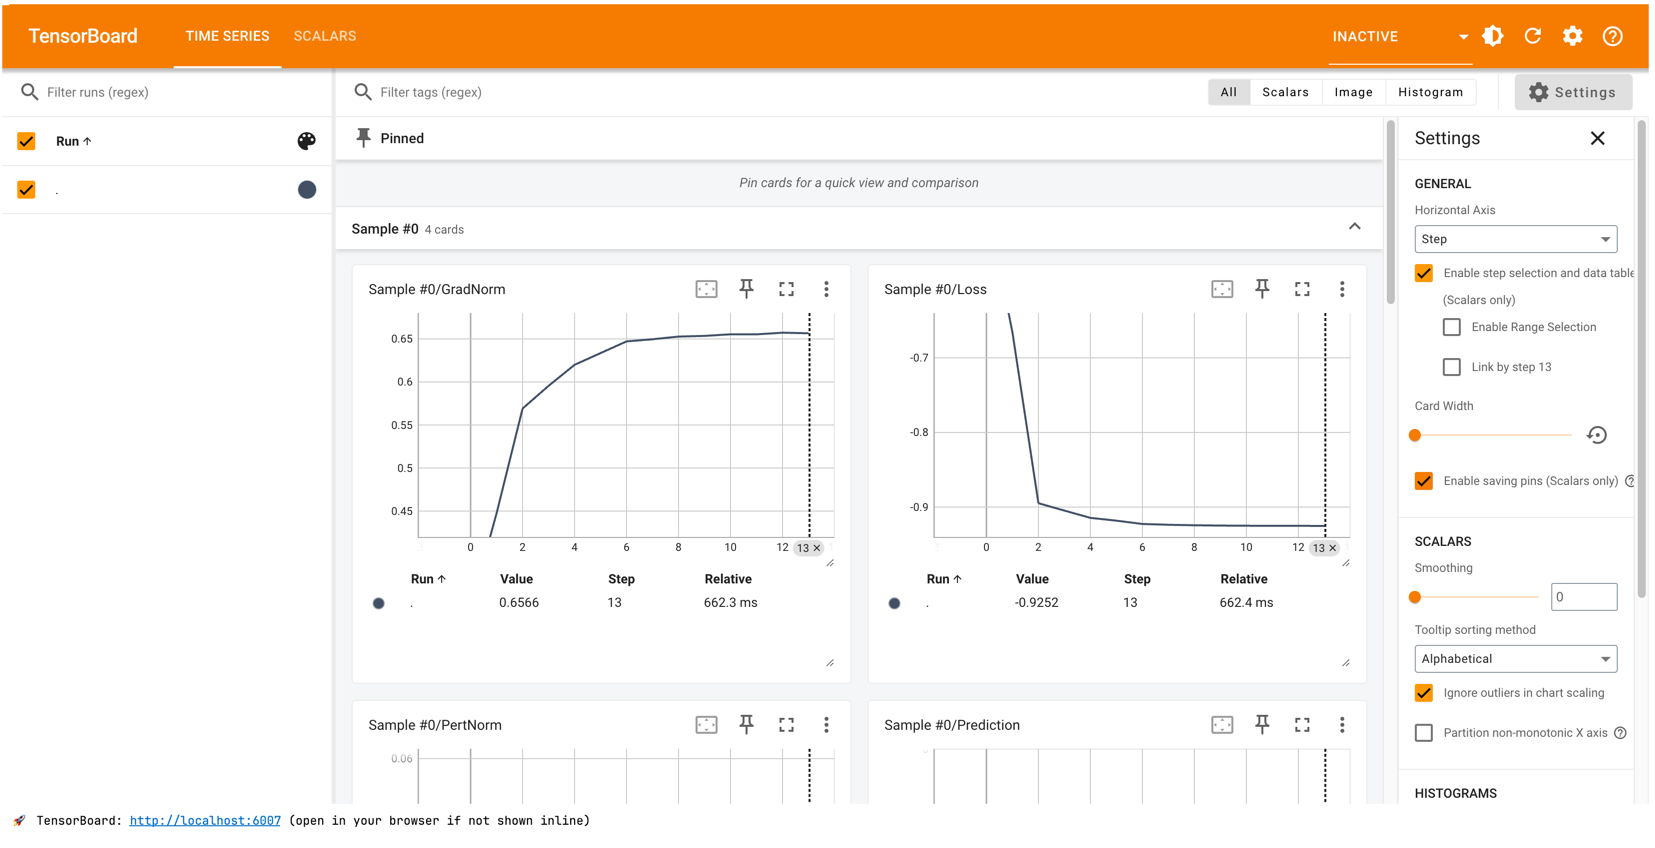